In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

In [204]:
# Load and preprocess data
file_path = "/kaggle/input/air-traffic-landings/air-traffic-landings-statistics.csv"
df = pd.read_csv(file_path)
df['Activity Period'] = pd.to_datetime(df['Activity Period'], format='%Y%m')
df = df.sort_values(by='Activity Period')

In [205]:

# Aggregate monthly landing counts
df_grouped = df.groupby('Activity Period').sum().reset_index()

In [206]:

# Create complete time series with all months
date_range = pd.date_range(start=df_grouped['Activity Period'].min(), 
                           end=df_grouped['Activity Period'].max(), 
                           freq='MS')
landing_counts = df_grouped.set_index('Activity Period').reindex(date_range, fill_value=0).reset_index().rename(columns={'index': 'Activity Period'})

# Feature engineering: Add cyclical month encoding
landing_counts['Month'] = landing_counts['Activity Period'].dt.month
landing_counts['Month_sin'] = np.sin(2 * np.pi * landing_counts['Month']/12)
landing_counts['Month_cos'] = np.cos(2 * np.pi * landing_counts['Month']/12)

In [207]:
# Scale features
features = ['Landing Count', 'Month_sin', 'Month_cos']
scaler = MinMaxScaler()
landing_counts[features] = scaler.fit_transform(landing_counts[features])

In [208]:
# Create sequences with multiple features
SEQ_LENGTH = 12  # Increased sequence length to capture 2-year patterns

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target is Landing Count
    return np.array(X), np.array(y)

data_values = landing_counts[features].values
X, y = create_sequences(data_values, SEQ_LENGTH)

In [209]:
# Split into train (80%) and test (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [210]:
# Model architecture with regularization
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(SEQ_LENGTH, len(features)),
         kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    LSTM(128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [218]:
# Compile with learning rate schedule
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Enhanced early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop], 
                    verbose=1)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step - loss: 0.0142 - val_loss: 0.0320
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0114 - val_loss: 0.0135
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0136 - val_loss: 0.0217
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0117 - val_loss: 0.0342
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0132 - val_loss: 0.0230
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0112 - val_loss: 0.0135
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0110 - val_loss: 0.0146
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0108 - val_loss: 0.0226
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0115 - val_loss: 0.0256
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0110 - val_loss: 0.0203
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0

In [212]:

# Prepare for inverse scaling
test_indices = range(split + SEQ_LENGTH, split + SEQ_LENGTH + len(y_test))
test_features = data_values[test_indices, 1:]

# Generate predictions
y_pred = model.predict(X_test)

# Inverse scale predictions and actual values
y_pred_scaled = np.concatenate([y_pred, test_features], axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_scaled)[:, 0]

y_test_scaled = np.concatenate([y_test.reshape(-1,1), test_features], axis=1)
y_test_inv = scaler.inverse_transform(y_test_scaled)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [213]:

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Improved Root Mean Squared Error (RMSE): {rmse}")

Improved Root Mean Squared Error (RMSE): 835.0510960938911


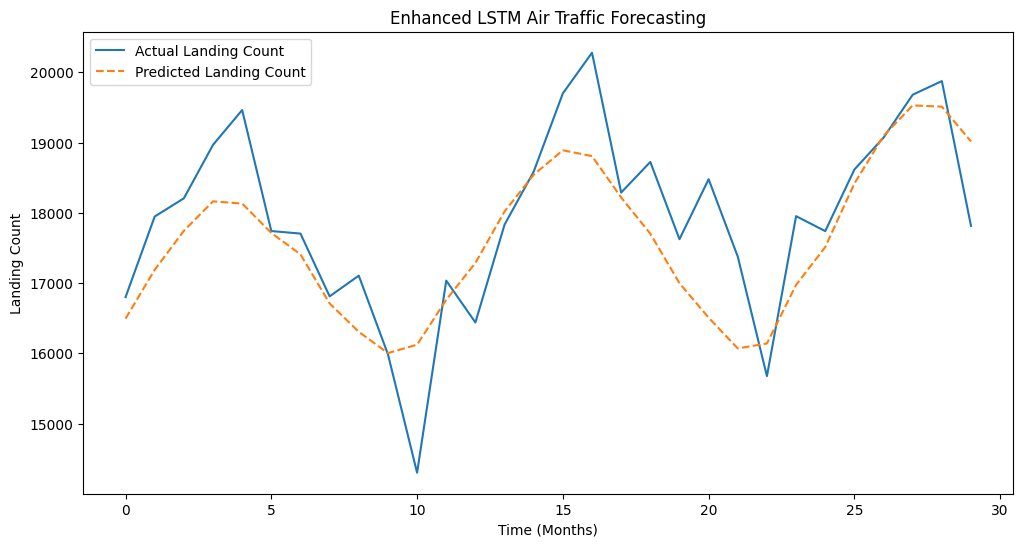

In [214]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Landing Count")
plt.plot(y_pred_inv, label="Predicted Landing Count", linestyle="dashed")
plt.xlabel("Time (Months)")
plt.ylabel("Landing Count")
plt.legend()
plt.title("Enhanced LSTM Air Traffic Forecasting")
plt.show()

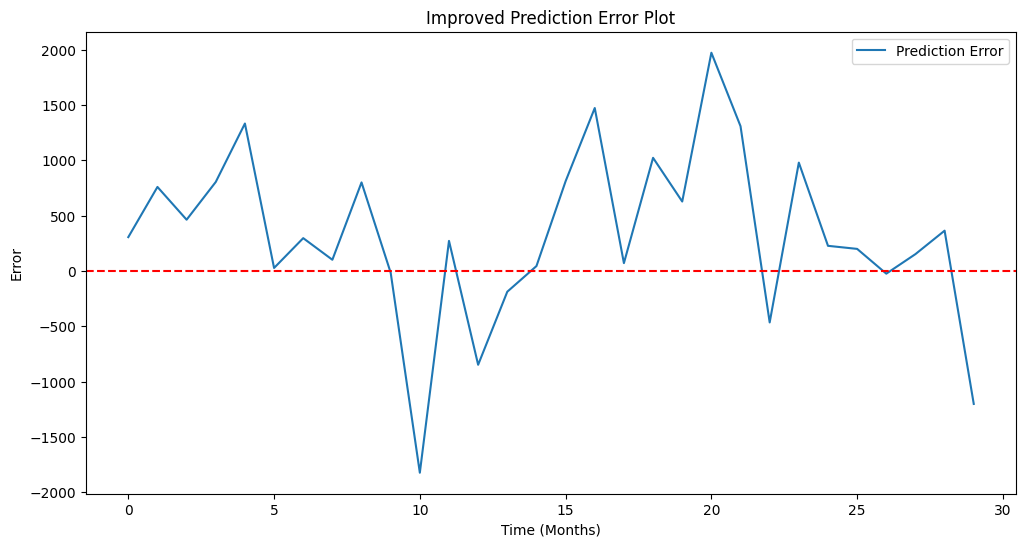

In [215]:
# Error plot
error = y_test_inv - y_pred_inv
plt.figure(figsize=(12, 6))
plt.plot(error, label="Prediction Error")
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Time (Months)")
plt.ylabel("Error")
plt.legend()
plt.title("Improved Prediction Error Plot")
plt.show()

In [219]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a threshold, for instance, using the median of actual landing counts
threshold = np.median(y_test_inv)  # You can also use y_test_inv.mean() if preferred

# Convert the continuous values to binary classes based on the threshold
y_test_binary = (y_test_inv >= threshold).astype(int)
y_pred_binary = (y_pred_inv >= threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.77
Precision: 0.83
Recall: 0.67
F1 Score: 0.74


In [217]:
from sklearn.metrics import mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")


RMSE: 835.05
MAE: 632.26
R^2 Score: 0.59


Linear Regression - RMSE: 0.05922978890595051, MAE: 0.048637162778417835
Random Forest - RMSE: 0.13534099807774916, MAE: 0.11730700631507078
XGBoost - RMSE: 0.16576233685689543, MAE: 0.14325447959549134


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
GRU - RMSE: 0.13357737237316666, MAE: 0.10301991269376463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
LSTM - RMSE: 1.0333897555068177, MAE: 1.0300597793800794

Model Comparison:
               Model      RMSE       MAE
0  Linear Regression  0.059230  0.048637
1      Random Forest  0.135341  0.117307
2            XGBoost  0.165762  0.143254
3                GRU  0.133577  0.103020
4               LSTM  1.033390  1.030060


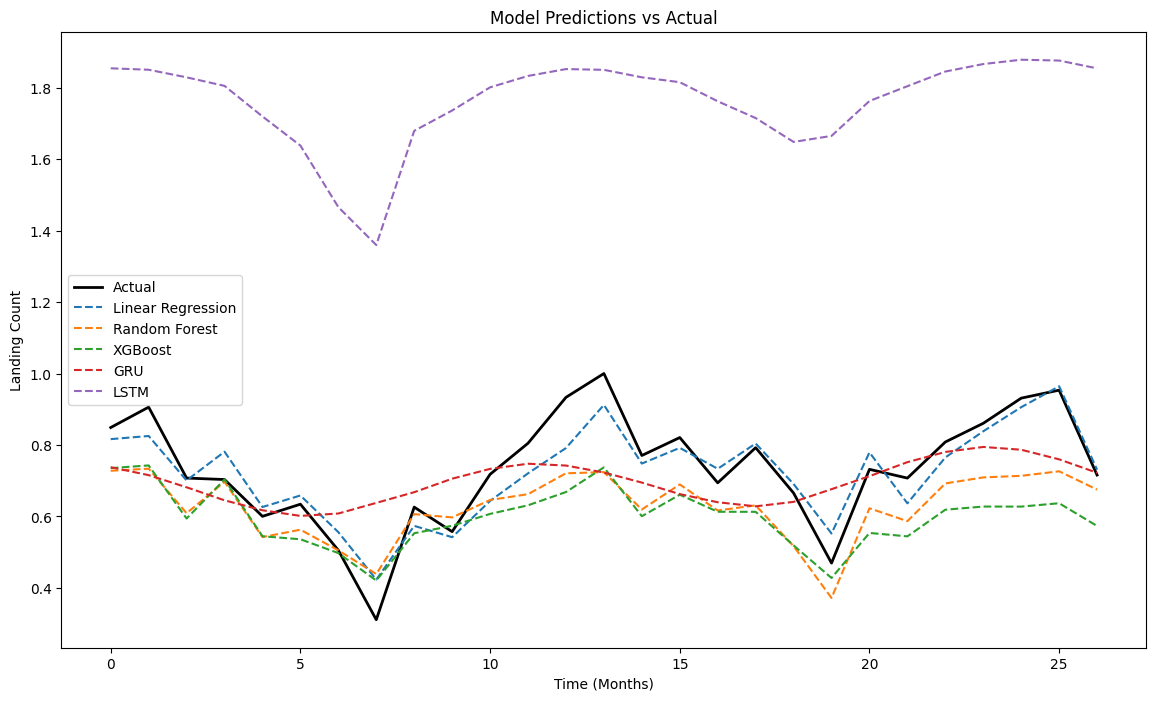

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Prepare data (same as before)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target is Landing Count
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
data_values = landing_counts[features].values
X, y = create_sequences(data_values, SEQ_LENGTH)

# Split dataset
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Flatten X for non-RNN models (Linear Regression, Random Forest, XGBoost)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}")
    return y_pred, rmse, mae

# 1. Linear Regression
lr_model = LinearRegression()
lr_pred, lr_rmse, lr_mae = evaluate_model(lr_model, X_train_flat, X_test_flat, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pred, rf_rmse, rf_mae = evaluate_model(rf_model, X_train_flat, X_test_flat, y_train, y_test, "Random Forest")

# 3. XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_pred, xgb_rmse, xgb_mae = evaluate_model(xgb_model, X_train_flat, X_test_flat, y_train, y_test, "XGBoost")

# 4. GRU Model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
gru_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
gru_pred = gru_model.predict(X_test)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_mae = mean_absolute_error(y_test, gru_pred)
print(f"GRU - RMSE: {gru_rmse}, MAE: {gru_mae}")

# 5. LSTM Model (your existing model)
lstm_pred = model.predict(X_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print(f"LSTM - RMSE: {lstm_rmse}, MAE: {lstm_mae}")

# Compare Results
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "GRU", "LSTM"],
    "RMSE": [lr_rmse, rf_rmse, xgb_rmse, gru_rmse, lstm_rmse],
    "MAE": [lr_mae, rf_mae, xgb_mae, gru_mae, lstm_mae]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Plot predictions vs. actual values
plt.figure(figsize=(14, 8))
plt.plot(y_test, label="Actual", color='black', linewidth=2)
plt.plot(lr_pred, label="Linear Regression", linestyle='dashed')
plt.plot(rf_pred, label="Random Forest", linestyle='dashed')
plt.plot(xgb_pred, label="XGBoost", linestyle='dashed')
plt.plot(gru_pred, label="GRU", linestyle='dashed')
plt.plot(lstm_pred, label="LSTM", linestyle='dashed')
plt.xlabel("Time (Months)")
plt.ylabel("Landing Count")
plt.title("Model Predictions vs Actual")
plt.legend()
plt.show()